In [52]:
import pandas as pd
import pylab
import json
%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid') # TODO: what did this do?
import numpy as np
from IPython.core import display
import psycopg2
import os
homedir = os.getenv("HOME")
with open(homedir + "/.pgpass",'r') as pgfile:
    pgdat = pgfile.read().strip().split(":")
    pgurl = pgdat[0]
    pgport = pgdat[1]
    pgdb = pgdat[2]
    pguser = pgdat[3]
    pgpass = pgdat[4]

%load_ext sql
from sqlalchemy import create_engine
# sql info: https://github.com/catherinedevlin/ipython-sql
# on error `pip install ipython-sql`
#uncomment for remote
#pgport=3333
pgport=5433
engine = create_engine('postgresql://postgres@localhost:%i/postgres' % pgport)
db = psycopg2.connect(host=pgurl, database=pgdb, user=pguser,password=pgpass,port=pgport)

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [53]:
def qry(q):
  return pd.read_sql_query(con = db, sql = q)
# pd.set_option("max_colwidth", None)
# pd.set_option('display.max_columns', None)
pd.set_option("display.latex.repr", False)
pd.set_option("display.latex.escape", True)

def iDisplay(v):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, "max_colwidth", None):
        display.display(v)


Count number of uploaded APK files

In [54]:
%%sql postgresql://postgres@localhost:$pgport/postgres
select count(*) from apks where apkname not like 'jar_%' and apkname not like 'spec_%';

1 rows affected.


count
56


In [55]:
%%sql
select
    (select count(*) from apks) as apk_count, 
    (select count(*) from inputs) as input_count, 
    (select count(*) from jobs) as job_count, 
    (select count(*) from resultdata) as result_data_count, 
    (select count(*) from results) as result_count

 * postgresql://postgres@localhost:5433/postgres
1 rows affected.


apk_count,input_count,job_count,result_data_count,result_count
58,1,11452,195,195


Print jobs and statuses

In [117]:
%%sql
select 
    (select count(*) from jobs where status = 'completed') as Completed_Jobs,
    (select count(*) from jobs where status = 'paused') as Paused_Jobs,
    (select count(*) from jobs where status = 'acquired') as Acquired_jobs,
    (select count(id) from jobs 
       where stderr like '%Exception%no active body present for method%') as Body_Exception,
    (select count(id) from jobs where stderr like '%an implementation is missing%') as unimplemented,
    (select count(id) from jobs where stderr like '%Exception%') as Exception,
    (select count(id) from jobs where stderr like '%no libz3java in java.library.path%') as path_exception,
    (select count(id) from jobs where stderr like '%Failed to parse reflective type reference%') as Refl_exception,
    (select count(id) from jobs where status like 'failed%') as worker_failure,
    (select count(id) from jobs where stdout like '%empty pred location%') as possible_cg_unsound,
    (select count(*) from jobs) as Total_Jobs

 * postgresql://postgres@localhost:5433/postgres
1 rows affected.


completed_jobs,paused_jobs,acquired_jobs,body_exception,unimplemented,exception,path_exception,refl_exception,worker_failure,possible_cg_unsound,total_jobs
490,0,6,3,0,8,0,0,0,0,11452


In [118]:
# find exceptions
#%%sql 
#select replace(cast(stderr as varchar),'$','\$') from jobs where stderr like '%Exception%' limit 1;
outs = %sql select stderr,config from jobs where stderr like '%Exception%' and stderr not like '%If should only have%' and stderr not like '%no active body present%' order by random() limit 3;
for out in outs:
    print(out[1])
    print(out[0])


 * postgresql://postgres@localhost:5433/postgres
0 rows affected.


In [63]:
# find exceptions
#%%sql 
#select replace(cast(stderr as varchar),'$','\$') from jobs where stderr like '%Exception%' limit 1;
out = %sql select stderr,config from jobs where stderr like '%an implementation is missing%' order by random() limit 1;
if(len(out) != 0):
    print(out[0][1])
    print(out[0][0])
else:
    print("none")


 * postgresql://postgres@localhost:5433/postgres
0 rows affected.
none


Get failing apks

In [69]:
%%sql
select cast(config::json->'apkPath' as text) from jobs 
        where stderr like '%Exception%' group by cast(config::json->'apkPath' as text) ;

 * postgresql://postgres@localhost:5433/postgres
2 rows affected.


text
"""${baseDir}/fdroid/dev.ukanth.ufirewall/3.5.3/apk/dev.ukanth.ufirewall_20220615.apk"""
"""${baseDir}/fdroid/net.osmand.plus/4.3.8/apk/net.osmand.plus_4308.apk"""


In [70]:
%%sql
select cast(config::json->'apkPath' as text) as app,count(*) as count from jobs group by app order by count desc;

 * postgresql://postgres@localhost:5433/postgres
53 rows affected.


app,count
"""${baseDir}/fdroid/com.shatteredpixel.shatteredpixeldungeon/1.4.3/apk/com.shatteredpixel.shatteredpixeldungeon_668.apk""",2562
"""${baseDir}/fdroid/net.osmand.plus/4.3.8/apk/net.osmand.plus_4308.apk""",1581
"""${baseDir}/fdroid/de.blau.android/18.1.1.0/apk/de.blau.android_2303.apk""",1128
"""${baseDir}/fdroid/org.mariotaku.twidere/4.1.8/apk/org.mariotaku.twidere_517.apk""",542
"""${baseDir}/fdroid/org.sufficientlysecure.keychain/5.8.2/apk/org.sufficientlysecure.keychain_58902.apk""",489
"""${baseDir}/fdroid/com.fsck.k9/6.503/apk/com.fsck.k9_35003.apk""",403
"""${baseDir}/fdroid/com.seafile.seadroid2/2.2.48/apk/com.seafile.seadroid2_123.apk""",379
"""${baseDir}/fdroid/be.digitalia.fosdem/2.1.1/apk/be.digitalia.fosdem_1900211.apk""",364
"""${baseDir}/fdroid/com.ichi2.anki/2.15.6/apk/com.ichi2.anki_21506300.apk""",323
"""${baseDir}/fdroid/com.byagowi.persiancalendar/7.8.0/apk/com.byagowi.persiancalendar_780.apk""",255


In [71]:
%%sql
select count(*),status from jobs group by status;

 * postgresql://postgres@localhost:5433/postgres
3 rows affected.


count,status
210,completed
11236,new
6,acquired


In [72]:
%%sql 
select cast(result::json->'summary' as varchar) as summary, cast(result::json->'maxPathCh' as varchar) as ch,count(*),avg(querytime),max(querytime) from results group by summary,ch order by summary,ch;

 * postgresql://postgres@localhost:5433/postgres
5 rows affected.


summary,ch,count,avg,max
"""\""Iclass java.lang.AssertionError\""""","""\""UnknownCharacterization\""""",1,0E-20,0
"""\""IIf should only have 1 or 2 next commands, next commands: List()\""""","""\""UnknownCharacterization\""""",1,1.00000000000000000000,1
"""\""Itimeout\""""","""\""UnknownCharacterization\""""",56,1763.5357142857142857,28796
"""\""Unreachable\""""","""\""UnknownCharacterization\""""",137,2.5109489051094891,96
"""\""Witnessed\""""","""\""UnknownCharacterization\""""",15,37.4666666666666667,505


In [88]:
%%sql 
select regexp_substr(cast(jobs.config::json->'apkPath' as varchar), 'AntennaPod|connectbot|sgtpuzzles') as benchmark, 
    regexp_substr(cast(results.qry::json->'s' as varchar), 'Dialog_dismiss|execute') as category, 
    count(*)
    from results inner join jobs on results.jobid=jobs.id 
    group by regexp_substr(cast(jobs.config::json->'apkPath' as varchar), 'AntennaPod|connectbot|sgtpuzzles'),
    regexp_substr(cast(results.qry::json->'s' as varchar), 'Dialog_dismiss|execute')

 * postgresql://postgres@localhost:5433/postgres
5 rows affected.


benchmark,category,count
connectbot,Dialog_dismiss,1
connectbot,execute,1
None,Dialog_dismiss,13
None,execute,8
None,None,231


In [93]:
res = %sql select distinct regexp_substr(cast(jobs.config::json->'apkPath' as varchar), '[a-zA-Z]*\.[a-zA-Z]*') as benchmark from results inner join jobs on results.jobid=jobs.id group by cast(jobs.config::json->'apkPath' as varchar)

len(res)

 * postgresql://postgres@localhost:5433/postgres
36 rows affected.


36

In [87]:
%%sql 
select regexp_substr(cast(jobs.config::json->'apkPath' as varchar), '[a-zA-Z]*\.[a-zA-Z]*') as benchmark, 
    regexp_substr(cast(results.qry::json->'s' as varchar), 'Dialog_dismiss|execute') as isDismiss, 
    cast(results.result::json->'summary' as varchar) as summary, count(*)
    from results inner join jobs on results.jobid=jobs.id 
    group by cast(jobs.config::json->'apkPath' as varchar),cast(results.result::json->'summary' as varchar),
    regexp_substr(cast(results.qry::json->'s' as varchar), 'Dialog_dismiss|execute')


 * postgresql://postgres@localhost:5433/postgres
76 rows affected.


benchmark,isdismiss,summary,count
be.digitalia,None,"""\""Itimeout\""""",1
be.digitalia,None,"""\""Unreachable\""""",3
com.byagowi,None,"""\""Itimeout\""""",1
com.byagowi,None,"""\""Unreachable\""""",3
com.duckduckgo,None,"""\""Itimeout\""""",1
com.duckduckgo,None,"""\""Unreachable\""""",2
com.fsck,None,"""\""Unreachable\""""",8
com.fsck,None,"""\""Witnessed\""""",1
com.gpl,execute,"""\""Itimeout\""""",2
com.gpl,None,"""\""Witnessed\""""",1


In [ ]:
%%sql
select cast(result::json->'summary' as varchar) as summary, count(*) from results, group by cast(result::json->'summary' as varchar)

In [ ]:
%%sql
select id from results where cast(results.result::json->'summary' as varchar) like '%Witnessed%'

In [ ]:
cfg = %sql select jobs.config from results inner join jobs on results.jobid=jobs.id where cast(results.result::json->'summary' as varchar) like '%Witnessed%' limit 1;
cfg[0][0]

In [ ]:
%%sql
select id,cast(result::json->'summary' as varchar) as summary,loc::json->'method'->>1 as clazz,loc::json->'method'->>2 from results order by random() limit 5;

Triage witness results
----------------------

In [ ]:
witnessesq = %sql \
select id,jobid,resultdata,loc::json->'method'->>1 as clazz,loc::json->'method'->>2 from results \
                where cast(result::json->'summary' as varchar) like '%Witnessed%' order by id asc;

witnessesdf = witnessesq.DataFrame()
witnessesdf.to_csv('triageWit.csv')

In [ ]:
witnessesq = %sql \
select id,jobid,resultdata,loc::json->'method'->>1 as clazz,loc::json->'method'->>2 from results \
                where cast(result::json->'summary' as varchar) like '%Itimeout%' and cast(result::json->'maxPathCh' as varchar) like '%MultiCallback%' order by id asc;

witnessesdf = witnessesq.DataFrame()
witnessesdf.to_csv('triageWitMultiTimeout.csv')

In [ ]:
%%sql 
select id,jobid,resultdata,loc::json->'method'->>1 as clazz, 
        replace(cast(loc::json->'line'->'str' as varchar),'$','\$') from results where id = 40;

Triage proven results
--------------------------

In [ ]:
%%sql 
select id,jobid,resultdata,loc::json->'method'->>1 as clazz,loc::json->'method'->>2 from results 
                where cast(result::json->'summary' as varchar) like '%Proven%' order by random() limit 10;

Triage unreachable results
--------------------------

In [ ]:
%%sql 
select id,jobid,resultdata,loc::json->'method'->>1 as clazz 
            from results where cast(result::json->'summary' as varchar) like '%Unreachable%' 
            order by random() limit 15;

In [ ]:
%%sql
select id,jobid,resultdata,loc::json->'method'->>1 as clazz, 
        replace(cast(loc::json->'method'->>0 as varchar),'$','\$') as mname, 
        replace(cast(loc::json->'line' as varchar),'$','\$') as location 
        from results where id = 15037;

In [ ]:
%%sql
select id,result,replace(cast(loc::json->'line' as varchar),'$','\$') as location 
    from results where loc like '%244 $r3%';

In [ ]:
%%sql
select replace(cast(loc as varchar),'$','\$') from results where id = 1494;

Runtime Stats
=============

 * postgresql://postgres@localhost:5433/postgres
504 rows affected.


Text(0.5, 0, 'time (hrs)')

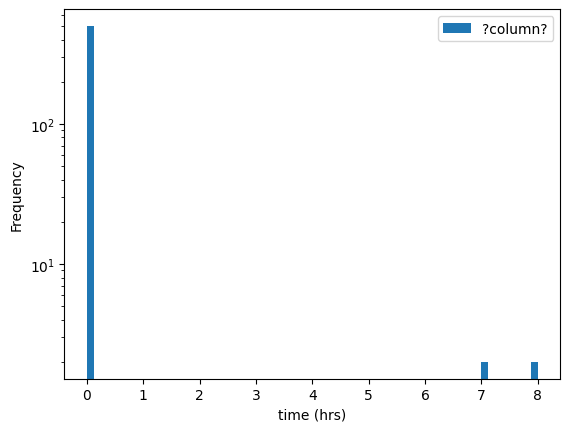

In [125]:
queryTime = %sql select querytime/60/60 from results;
tplt = queryTime.DataFrame().plot.hist(bins=64)
tplt.set_yscale('log')
# tplt.set_xscale('log')
tplt.set_xlabel('time (hrs)')
# split this into proven and witnessed

 * postgresql://postgres@localhost:5433/postgres
253 rows affected.


Text(0.5, 0, 'time (min)')

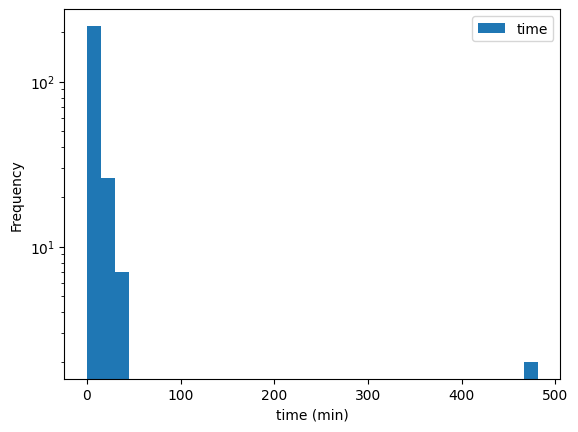

In [96]:
# Job runtimes
runtimes = %sql select ended - started as time from jobs where ended is not NULL;
runtimesDF = runtimes.DataFrame()
runtimesDF['time'] = runtimesDF['time'].apply(lambda x: x.total_seconds() / (60))
tplt = runtimesDF.plot.hist(bins=32)
tplt.set_yscale('log')
tplt.set_xlabel('time (min)')

 * postgresql://postgres@localhost:5433/postgres
253 rows affected.


/tmp/ipykernel_2764775/1841651425.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(rtvtDF['started'], rtvtDF['time'], marker='*', linestyle='')


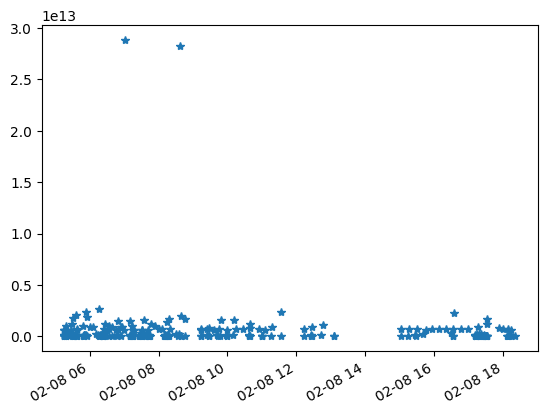

In [97]:
# Plot job time trend
rtvt = %sql select started, ended - started as time from jobs where ended is not NULL;
rtvtDF = rtvt.DataFrame()
rtvtDF.sort_values('started', ascending=True)
fig, ax = plt.subplots()
ax.plot_date(rtvtDF['started'], rtvtDF['time'], marker='*', linestyle='')

fig.autofmt_xdate()
plt.show()


Total job time

In [98]:
%%sql
select sum(ended-started) from jobs where ended is not NULL;

 * postgresql://postgres@localhost:5433/postgres
1 rows affected.


sum
"1 day, 17:59:55.770000"


In [101]:
%%sql
select avg(querytime) from results;

 * postgresql://postgres@localhost:5433/postgres
1 rows affected.


avg
412.6406250000000000


In [ ]:
%%sql
select now() - min(started) from jobs;

Size of postgres data
=====================

In [94]:
%%sql
WITH RECURSIVE pg_inherit(inhrelid, inhparent) AS
    (select inhrelid, inhparent
    FROM pg_inherits
    UNION
    SELECT child.inhrelid, parent.inhparent
    FROM pg_inherit child, pg_inherits parent
    WHERE child.inhparent = parent.inhrelid),
pg_inherit_short AS (SELECT * FROM pg_inherit WHERE inhparent NOT IN (SELECT inhrelid FROM pg_inherit))
SELECT table_schema
    , TABLE_NAME
    , row_estimate
    , pg_size_pretty(total_bytes) AS total
    , pg_size_pretty(index_bytes) AS INDEX
    , pg_size_pretty(toast_bytes) AS toast
    , pg_size_pretty(table_bytes) AS TABLE
  FROM (
    SELECT *, total_bytes-index_bytes-COALESCE(toast_bytes,0) AS table_bytes
    FROM (
         SELECT c.oid
              , nspname AS table_schema
              , relname AS TABLE_NAME
              , SUM(c.reltuples) OVER (partition BY parent) AS row_estimate
              , SUM(pg_total_relation_size(c.oid)) OVER (partition BY parent) AS total_bytes
              , SUM(pg_indexes_size(c.oid)) OVER (partition BY parent) AS index_bytes
              , SUM(pg_total_relation_size(reltoastrelid)) OVER (partition BY parent) AS toast_bytes
              , parent
          FROM (
                SELECT pg_class.oid
                    , reltuples
                    , relname
                    , relnamespace
                    , pg_class.reltoastrelid
                    , COALESCE(inhparent, pg_class.oid) parent
                FROM pg_class
                    LEFT JOIN pg_inherit_short ON inhrelid = oid
                WHERE relkind IN ('r', 'p')
             ) c
             LEFT JOIN pg_namespace n ON n.oid = c.relnamespace
  ) a
  WHERE oid = parent
) a
ORDER BY total_bytes DESC limit 5;

 * postgresql://postgres@localhost:5433/postgres
5 rows affected.


table_schema,table_name,row_estimate,total,index,toast,table
public,apks,58.0,811 MB,0 bytes,811 MB,24 kB
public,jobs,11452.0,16 MB,464 kB,120 kB,15 MB
public,results,255.0,1952 kB,1128 kB,432 kB,392 kB
pg_catalog,pg_proc,3244.0,1192 kB,336 kB,56 kB,800 kB
public,resultdata,240.0,1016 kB,88 kB,520 kB,408 kB


Inspection of exceptions
========================

In [ ]:
%%sql
select id,config::json->'apkPath',replace(stderr,'$','\$') from jobs where stderr like '%Exception%';

In [ ]:
#count of total results
%sql select count(*) as Total_locations_computed from results